# Задание 1

Импортируем необходимые модули

In [34]:
import random
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tabulate
from typing import Callable
from mpl_toolkits.mplot3d import Axes3D

Сделаем вспомогательную функцию "сломается ли"

In [35]:
def it_will_break(p: float) -> bool:
    r = random.random()
    if r < p:
        return True 
    return False

Напишем функции моделирования схемы альфа и подсчета аналитического решения

In [36]:
def alpha_day(trip_count: int, pa, pb: float) -> int:
    count = 0
    fixing = False
    for i in range(trip_count):
        if not fixing:
            count += 1
            fixing = it_will_break(pa)
        else:
            fixing = False
    return count


def alpha_real(trip_count: int, pa, pb: float) -> float:
    return trip_count/(1+pa)+pa*(1-(-pa)**trip_count)/(1+pa)**2

Аналогично для схемы бета

In [37]:
def beta_day(trip_count: int, pa, pb: float) -> int:
    count = 0
    damage = False
    for i in range(trip_count):
        count += 1
        if damage and it_will_break(pb):
            break
        else:
            damage = damage or it_will_break(pa)
    return count


def beta_real(trip_count: int, pa, pb: float) -> float:
    if pa == 0 or pb == 0 or pa-pb == 0:
        return 0
    return ((pa**2)*(1-(1-pb)**trip_count)-(pb**2)*(1-(1-pa)**trip_count))/(pa*pb*(pa-pb))

Сделаем функцию подсчета среднего числа рейсов за N дней

In [38]:
def strategy_period_mean(days, trip_count, pa, pb: int, day_func: Callable[[int, float, float], int]) -> float:
    period_data = list()
    for i in range(days):
        period_data.append(day_func(trip_count, pa, pb))
    return np.mean(np.array(period_data))

Протестируем

In [39]:
days_count = 500000
trip_count = 10
pa = 0.4
pb = 0.7

a_model = strategy_period_mean(days_count, trip_count, pa, pb, alpha_day)
a_real = alpha_real(trip_count, pa, pb)

b_model = strategy_period_mean(days_count, trip_count, pa, pb, beta_day)
b_real = beta_real(trip_count, pa, pb)

print(f'Days: {days_count}')
print(f'Trips per day: {trip_count}')
print(f'PA: {pa}')
print(f'PB: {pb}')
print()
print(f'Alpha model: {a_model:8.5f}')
print(f'Alpha real:  {a_real:8.5f}')
print(f'Beta model:  {b_model:8.5f}')
print(f'Beta real:   {b_real:8.5f}')

Days: 500000
Trips per day: 10
PA: 0.4
PB: 0.7

Alpha model:  7.34744
Alpha real:   7.34692
Beta model:   3.89120
Beta real:    3.89331


# Задание 2

Удобным образом генерируем дни

In [40]:
day0 = 1
days_max = 10000
days = [day0]

while (day0 < days_max):
    day0 *= 2
    days.append(int(day0))
    day0 *= 2.5
    days.append(int(day0))
    day0*=2
    days.append(int(day0))

# this will generate [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
#                     |                                     |
#                     |                                     |
#                     1 is day0, power of ten             1000 is days_max, also power of ten

Генерируем датасет и подсчитываем точные значения

In [41]:
trip_count = 10
pa = 0.4
pb = 0.7

a_real = alpha_real(trip_count, pa, pb)
b_real = beta_real(trip_count, pa, pb)

data = list()

for days_count in days:
    a_model = strategy_period_mean(days_count, trip_count, pa, pb, alpha_day)
    b_model = strategy_period_mean(days_count, trip_count, pa, pb, beta_day)
    data.append(['alpha', str(days_count), a_model])
    data.append(['alpha_real', str(days_count), a_real])
    data.append(['beta', str(days_count), b_model])
    data.append(['beta_real', str(days_count), b_real])


df = pd.DataFrame(data, columns = ['strategy', 'days', 'value'])
# df.sort_values(by=['strategy', 'days'], inplace=True)
print(df)

      strategy   days     value
0        alpha      1  7.000000
1   alpha_real      1  7.346917
2         beta      1  4.000000
3    beta_real      1  3.893311
4        alpha      2  7.000000
5   alpha_real      2  7.346917
6         beta      2  2.000000
7    beta_real      2  3.893311
8        alpha      5  7.000000
9   alpha_real      5  7.346917
10        beta      5  4.200000
11   beta_real      5  3.893311
12       alpha     10  7.800000
13  alpha_real     10  7.346917
14        beta     10  3.800000
15   beta_real     10  3.893311
16       alpha     20  7.250000
17  alpha_real     20  7.346917
18        beta     20  4.200000
19   beta_real     20  3.893311
20       alpha     50  7.720000
21  alpha_real     50  7.346917
22        beta     50  4.100000
23   beta_real     50  3.893311
24       alpha    100  7.420000
25  alpha_real    100  7.346917
26        beta    100  4.070000
27   beta_real    100  3.893311
28       alpha    200  7.275000
29  alpha_real    200  7.346917
30      

Построим линейные графики

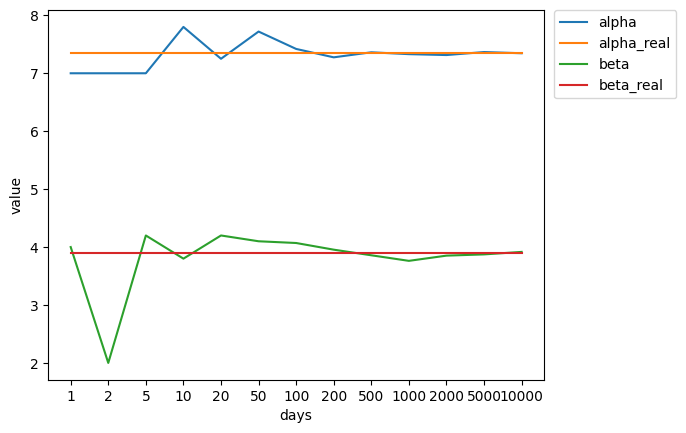

In [42]:
g = seaborn.lineplot(df, x='days', y='value', hue='strategy')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) # для вывода легенды справа

# Задание 3

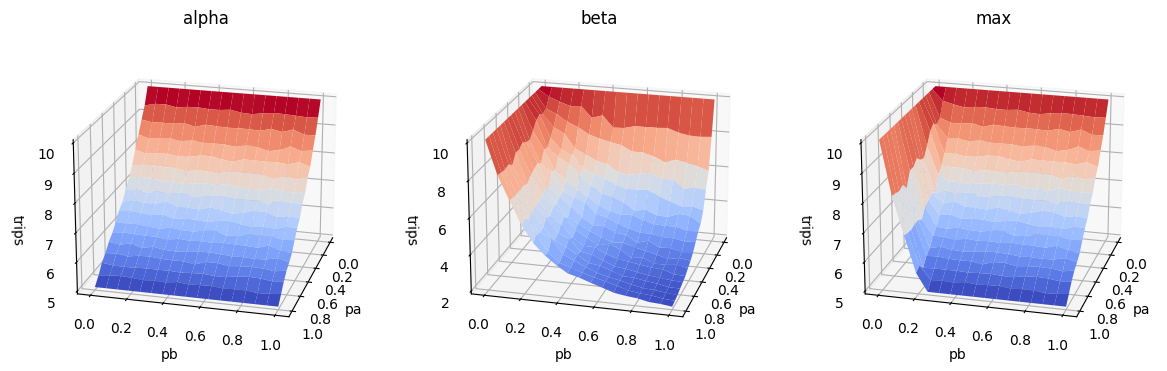

In [79]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

# angle of subplots
vert_angle = 20
rotation_angle = 15

# axis labels name
xlabel = 'pa'
ylabel = 'pb'
zlabel = 'trips'

nrows = 1      # subplots rows count
ncols = 3      # subplots columns count

fig = plt.figure(figsize=plt.figaspect(nrows/ncols))        # can break if nrows != 1

xy_precision = 16                                           # xy_precision + 1 = count of x, y delimeters 
X = [i/xy_precision for i in range(0, xy_precision + 1)]    # pa
Y = X.copy()                                                # pb = pa
X, Y = np.meshgrid(X, Y)                                    # numpy likes it <3


def draw_graphic(plt_number: int, Z: np.ndarray, title: str) -> None:

    ax = fig.add_subplot(nrows, ncols, plt_number, projection='3d')     # make axis
    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=True)        # make surface on axis

    # some historical artefacts:
    
    # ax.zaxis.set_major_locator(LinearLocator(10))         # dont know about it, maybe for intercative graphics
    # ax.zaxis.set_major_formatter('{x:.02f}')              # z axis formatter
    # fig.colorbar(surf, shrink=0.5, aspect=5)              # colorbar

    ax.view_init(vert_angle, rotation_angle)                # axis view angle
    ax.set_xlabel(xlabel)                                   # axis labels
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)                                     # set subplot title


trip_count = 10                                             # trips per day
days = 300                                                  # models days count
np_strategy_period = np.vectorize(strategy_period_mean)     # np version of strategy_period_mean function

Za = np_strategy_period(days, trip_count, X, Y, alpha_day)
Zb = np_strategy_period(days, trip_count, X, Y, beta_day)
Zm = np.maximum(Za, Zb)

draw_graphic(1, Za, 'alpha')
draw_graphic(2, Zb, 'beta')
draw_graphic(3, Zm, 'max')

plt.show()

### Задание 4

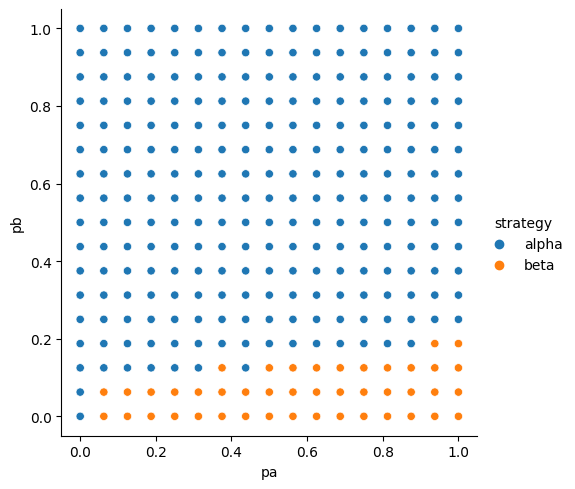

In [52]:
data = []
for i, j in np.ndindex(X.shape):
    
    # take max between alpha and beta strategy
    Z = (Za[i, j], 'alpha')
    if Zb[i, j] > Za[i, j]:
        Z = (Zb[i, j], 'beta')

    data.append([X[i, j], Y[i, j], Z[0], Z[1]])

df = pd.DataFrame(data, columns = ['pa', 'pb', 'val', 'strategy'])

seaborn.relplot(data=df, x='pa', y='pb', hue='strategy')